In [132]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.offline as pyo

import re
import requests
from tqdm import tqdm
from datetime import datetime

In [133]:
pio.renderers.default = 'pdf'
pyo.init_notebook_mode(connected=True)

In [134]:
df = pd.read_parquet('../Data/full_data_5years.parquet')

# Main

In [135]:
df.drop(['date', 'key_words'], axis=1).describe(include='all')

,website,section,url,header,body
count,226975,226975,226975,226975,226975
unique,4,482,226975,222766,225160
top,РИА,Экономика,https://ria.ru/20190315/1551809974.html,Новости компаний — обзоры прессы перед открыти...,отчет
freq,81729,66650,1,644,776


> __Conclusions:__ 
> 1. You can notice that we have no gaps in the data 
> 2. You may notice that we have news with similar headlines, as a result, you will need to understand whether such news are duplicates and decide what to do with them 
> 3. You can notice that we have news with completely repeating texts of short length, which most likely indicates the need to get rid of such 'empty' news

# URL

In [136]:
df[['url']].groupby('url').value_counts().sort_values().tail()

url
https://ria.ru/20230707/kuban-1882789816.html         1
https://ria.ru/20230707/naftogaz-1882766020.html      1
https://ria.ru/20230707/nauka-1882773354.html         1
https://ria.ru/20230707/avtomobili-1882758305.html    1
https://www.kommersant.ru/gallery/6239712             1
Name: count, dtype: int64

> __Conclusions:__ All our URLs are unique

# Body

## Let's clean the texts from uninformative parts

### First of all, let’s get rid of external links in texts (in test format) 

In [137]:
patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
]

In [138]:
links = []
ids = []

for i in tqdm(range(df.shape[0])):
    if df.iloc[i,:].body is not None:
        for pattern in patterns:
            lst_help = re.findall(pattern, df.iloc[i,:].body)
            if lst_help:
                links.extend(lst_help)
                ids.append(i)

# print(len(links))
# print(links)

  0%|          | 0/226975 [00:00<?, ?it/s]

100%|██████████| 226975/226975 [02:44<00:00, 1380.39it/s]


Now, after we have made sure that our regex pattern correctly finds external links in texts (at least a significant part of them), we can get rid of them in the texts themselves

In [139]:
def remove_links(text):
    patterns = [
    r'(?:(?:https?|ftp):\/\/|www\.)[-A-Za-z0-9+&@#\/%?=~_|!:,.;]*[-A-Za-z0-9+&@#\/%=~_|]',
    r'(?<=\s)fomag\.ru[^ ]*',
    r'(?<=\n|1)[^ ]*\.html',
    r'(?<=\n)[^ ]*\.pdf',
    r'(?<=\s)tass\.ru[^ ]*',
    r'(?<=\s)t.me[^ ]*'
    ]
    
    if text is not None:
        for pattern in patterns:
            text = re.sub(pattern, ' ', text)
    
    return text

#vectorized_remove_links = np.vectorize(remove_links)

In [140]:
df_new = df.copy()
for i in tqdm(range(df_new.shape[0])):
    df_new.loc[i, 'body'] = remove_links(df_new.loc[i, 'body'])

100%|██████████| 226975/226975 [01:33<00:00, 2417.55it/s]


### Now let’s go through individual portals in which the same pieces of text are repeated and get rid of them (in our case, these are RIA and Interfax)

In [141]:
def sub_ria(text):
    pattern = r'^.*(?:—|-|–) РИА Новости(?:.|,)'
    return re.sub(pattern, ' ', text, count=1)

#vectorized_sub_ria = np.vectorize(sub_ria)

for i in tqdm(range(df_new.shape[0])):
    df_new.loc[i, 'body'] = sub_ria(df_new.loc[i, 'body'])

  0%|          | 0/226975 [00:00<?, ?it/s]

100%|██████████| 226975/226975 [00:29<00:00, 7767.21it/s]


In [142]:
def sub_interfax(text):
    pattern = r'^.*INTERFAX.RU'
    return re.sub(pattern, ' ', text, count=1)

#vectorized_sub_interfax = np.vectorize(sub_interfax)

for i in tqdm(range(df_new.shape[0])):
    df_new.loc[i, 'body'] = sub_interfax(df_new.loc[i, 'body'])

  0%|          | 0/226975 [00:00<?, ?it/s]

100%|██████████| 226975/226975 [00:26<00:00, 8483.90it/s]


In [155]:
def sub_kommersant(text):
    patterns = [
    r'\\nФото.*?\\n',
    r'\\n([А-ЯЁ][а-яё]* [А-ЯЁ][а-яё]*).{0,120}$',
    r'\\nЕще больше новостей в Telegram-канале «Коммерсантъ»[.]',
    r'Интервью взял.*',
    r'(Подробн.{2,4}|О) .*(«Ъ»|“Ъ”|материале|публикации).*$'
    ]
    
    if text is not None:
        for pattern in patterns:
            text = re.sub(pattern, ' ', text)
    
    return text


for i in tqdm(df_new.loc[df_new['website'] == 'Kommersant', 'body'].index):
    df_new.loc[i, 'body'] = sub_kommersant(df_new.loc[i, 'body'])

100%|██████████| 15118/15118 [00:02<00:00, 5461.70it/s]


## After we have gotten rid of uninformative and unnecessary parts in news texts, we can look at the distribution of text lengths and, as a result, get rid of news with very short (almost no information) texts and news with completely duplicate texts

### First, let's delete short news from all portals

In [156]:
df_new.loc[:, 'body_length'] = df_new['body'].apply(len)

In [157]:
quantile_lst = []
for i in [round(0.01 + 1/100*i, 2) for i in range(10)]:
    length = df_new[["body_length"]].quantile(i).iloc[0]
    quantile_lst.append(length)
    
quantile_lst = [int(i) for i in quantile_lst]

In [158]:
for i, quantile_len in enumerate(quantile_lst):
    print(f'Quantile {(i+1)/100} with length: {quantile_len}')
    print(df_new[df_new['body_length']>quantile_len].sort_values(by='body_length').iloc[0,:].body)
    print('-------------------------------------------------------------------------------------')

Quantile 0.01 with length: 55
Ютэйр: с утра +15% и новые максимумы с февраля 2015 года
-------------------------------------------------------------------------------------
Quantile 0.02 with length: 112
Инфраструктура «Почты России» готова к запуску эксперимента по дистанционной продаже вина — почтовый оператор.

 
-------------------------------------------------------------------------------------
Quantile 0.03 with length: 183
 👉 ФРС захочет повысить ставки до конца 2022 года, меня нисколько не удивит, если в следующем году будет одно или два повышения ставок

👉 Политика ФРС все равно останется стимулирующей
-------------------------------------------------------------------------------------
Quantile 0.04 with length: 247
«Русгидро» объявляет о подаче заявления о делистинге депозитарных расписок с Лондонской фондовой биржи и о предстоящем прекращении программы депозитарных расписок

«Русгидро» прекращает обращение депозитарных расписок на Лондонской бирже (fomag.ru)
--------------

You can notice that starting from the 0.04 quantile, the news is already quite informative, therefore, we will delete all news with texts of length less than 200

In [159]:
df_new.drop(df_new[df_new['body_length'] < 200].index, inplace=True)

In [160]:
df_new[['body']].describe()

,body
count,219683
unique,219424
top,Элементы предполагаемой зенитной управляемой р...
freq,12


### We see that we still have news with duplicate texts, we need to get rid of these duplicates

In [161]:
sum(df_new['body'].value_counts()[df_new['body'].value_counts() > 1])

368

Let's just drop duplicated news, as there are not much of them.

In [162]:
df_new = df_new.drop_duplicates(subset=['body'], keep=False)

In [163]:
df_new[['body']].describe()

,body
count,219315
unique,219315
top,Перспективы продажи американского сжиженного...
freq,1


### After the cleaning, you can also look at the distribution of text lengths relative to different portals

In [164]:
df_new['website'] = df_new['website'].replace({'РИА':'Ria', 'Интерфакс':'Interfax'})

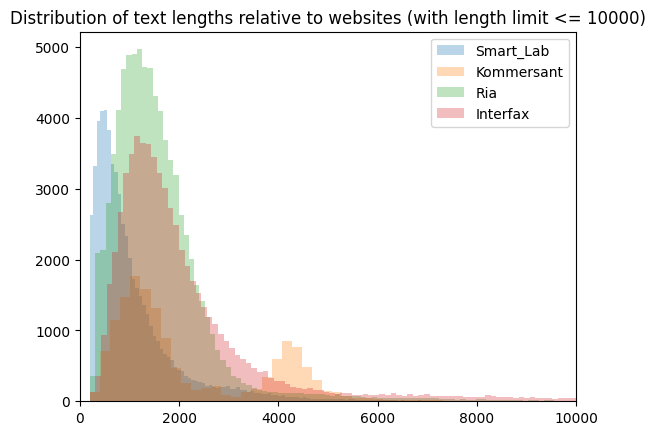

In [165]:
for portal in ['Smart_Lab', 'Kommersant', 'Ria', 'Interfax']:
    plt.hist(df_new[df_new['website']==portal].body_length, bins=400, alpha=0.3, label=portal)

plt.xlim(0, 10000)

plt.title('Distribution of text lengths relative to websites (with length limit <= 10000)')
plt.legend()
plt.show()

> __Conclusions:__ 
> 1. We cleaned the texts from uninformative and unnecessary parts that could harm the quality of our subsequent models 
> 2. After cleaning the news texts, we got rid of practically uninformative and duplicate news 
> 3. You can notice that our distribution of lengths of news texts is determined by the website from which the news was taken, at the moment this does not give us any specific information (except that we have a fairly diverse corpus of texts), but we will keep this in mind when training models later

# Section

> __Reasoning:__ Initially, there was an idea to get rid of news that does not fit our topic based on inappropriate sections, but, as a result, we decided that we will weed out inappropriate news at the entity extraction stage, since the news in this case will be considered inappropriate if does not contain the entity(ies) we need. 
> 
> As a result, at the moment, we decided not to make any transformations based on information about the section from which the news was taken

# Header

In [166]:
df_new[['header']].groupby('header').value_counts().sort_values().tail(100)

header
ЦБ отозвал лицензии у двух банков                                              4
В России подешевели огурцы и помидоры                                          4
"Газпром" заявил, что подает газ для транзита через Украину штатно             4
В России подешевели огурцы                                                     4
Акции Сбербанка обновили исторический максимум                                 4
                                                                            ... 
Цена вопроса                                                                  25
Оперштаб назвал регионы с наименьшими темпами прироста случаев COVID-19       29
"Газпром" штатно подает газ для транзита через Украину                        43
"Газпром" подает газ через Украину на ГИС "Суджа" в подтвержденном объеме     61
Новости компаний — обзоры прессы перед открытием рынка                       644
Name: count, Length: 100, dtype: int64

In [167]:
df_new[df_new['header'] == '"Газпром" подает газ через Украину на ГИС "Суджа" в подтвержденном объеме']

,website,section,url,header,body,date,key_words,body_length
48385,Ria,Экономика,https://ria.ru/20220602/gaz-1792540984.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",10:07 02.06.2022,"[Экономика, Украина, Луганская Народная Респуб...",934
48889,Ria,Экономика,https://ria.ru/20220603/gaz-1792798605.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",09:59 03.06.2022\n ...,"[Экономика, Газпром, Украина, Россия, Европа, ...",949
49042,Ria,Экономика,https://ria.ru/20220519/gaz-1789388068.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",09:59 19.05.2022\n ...,"[Экономика, Газпром, Россия, Украина, Луганска...",932
49339,Ria,Экономика,https://ria.ru/20220520/gaz-1789652759.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",10:00 20.05.2022\n ...,"[Экономика, Газпром, Украина, Европа, Санкции ...",932
50182,Ria,Экономика,https://ria.ru/20220526/gaz-1790802390.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",11:45 26.05.2022,"[Экономика, Украина, Луганская Народная Респуб...",949
...,...,...,...,...,...,...,...,...
76770,Ria,Экономика,https://ria.ru/20230611/gaz-1877479000.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",10:04 11.06.2023,"[Экономика, Украина, Европа, Сергей Куприянов,...",1776
77032,Ria,Экономика,https://ria.ru/20230205/gaz-1849822062.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",09:59 05.02.2023,"[Экономика, Украина, Европа, Луганская Народна...",1868
77075,Ria,Экономика,https://ria.ru/20230128/gaz-1848061770.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",10:02 28.01.2023,"[Экономика, Украина, Европа, Луганская Народна...",1376
77261,Ria,Экономика,https://ria.ru/20230917/gaz-1896785966.html,"""Газпром"" подает газ через Украину на ГИС ""Суд...","""Газпром"" подает газ через Украину в подтвер...",10:27 17.09.2023,"[Экономика, Украина, Луганская Народная Респуб...",1154


> __Conclusions:__ As you can see, a lot of news has repeating headlines, but these news are not duplicates, since the date of their publication and the text are different, as a result, these are just different news, written according to similar templates under the same headings. We will not get rid of such news

# Date

Processing dates, calculating the number of news items per date

## Interfax

In [173]:
df_interfax = df_new[df_new['website']=='Interfax']
df_interfax = df_interfax.reset_index()
df_interfax = df_interfax.drop('index', axis=1)

In [174]:
months = {"января": "1", "февраля": "2", "марта": "3", "апреля": "4", "мая": "5", "июня": "6", "июля":"7",
          "августа":"8", "сентября":"9", "октября":"10", "ноября":"11", "декабря":"12"}


def monthconvert(date):
    for word, initial in months.items():
        date = date.replace(word.lower(), initial)
    return date

In [175]:
def datechanger(date):
    date = monthconvert(date)
    datetime_object = datetime.strptime(date, '%H:%M, %d %m %Y')
    return datetime_object

In [176]:
for i in range(len(df_interfax)):
    df_interfax.loc[i, 'date'] = datechanger(df_interfax.date[i])

In [177]:
df_interfax['datetime'] = df_interfax['date']

In [178]:
dates = []
for i in range(len(df_interfax)):
    dates.append(datetime.date(df_interfax['datetime'][i]))
df_interfax['date'] = dates

In [179]:
years = ['2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01', '2024-01-01']
working_days = []
for i in range(len(years) - 1):
    start = years[i]
    finish = years[i+1]
    l = requests.get('http://iss.moex.com/iss/engines/stock/markets/shares/securities/sber/candles.json?from={}&till={}&interval=24'.format(start, finish)).json()
    for day in range(len(l['candles']['data'])):
        working_days.append(datetime.strptime(l['candles']['data'][day][6], '%Y-%m-%d %H:%M:%S'))

In [180]:
weekend = pd.Series()
s = pd.date_range('2019-01-01', '2024-01-01', freq='D').to_series()
for i in s:
    if i not in working_days:
        weekend[i] = 1
    else:
        weekend[i] = 0

In [181]:
news_by_date = df_interfax.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

In [182]:
def plot_news(source:str):
    fig = go.Figure()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=news_by_date.index, y=weekend,
                             fill = 'tonexty', fillcolor = 'rgba(255, 0, 0, 0.4)',
                             line_shape = 'hv', line_color = 'rgba(0,0,0,0)',
                             showlegend = True, name='Weekends and holidays'
                            ),
                row = 1, col = 1, secondary_y=True)

    fig.add_trace(
        go.Scatter(x = list(news_by_date.index), y=list(news_by_date.values), 
                   line_color='rgba(65,105,225,1)', name='News per day'))

    fig.update_layout(
        title = 'News per day {}'.format(source),
        width=1200,
        height=450,
        xaxis=dict(
            rangeselector=dict(),
            rangeslider=dict(
                visible=True
            ),
            type="date"
        )
    )

    fig.show(renderer='png')

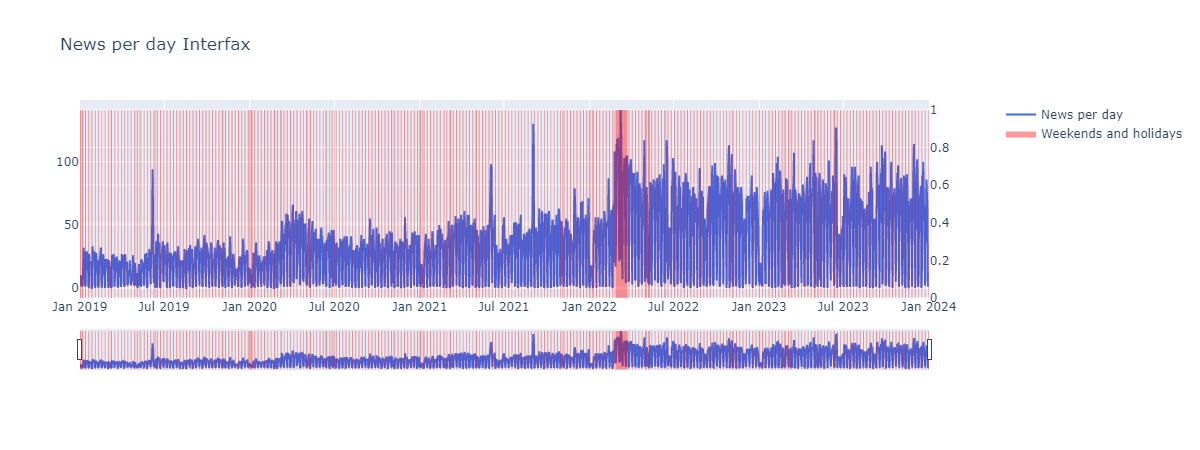

In [183]:
plot_news('Interfax')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items was approximately 25-30 before 2022. Since 2022 it has been at level of 75 news per day. Variance also increased.

## Ria

In [184]:
df_ria = df_new[df_new['website']=='Ria']
df_ria = df_ria.reset_index()
df_ria = df_ria.drop('index', axis=1)

In [185]:
dates_init = []
for i in df_ria.date:
    pattern = r'^([0-1]?[0-9]|2?[0-3]):([0-5]\d)\s([1-9]|([012][0-9])|(3[01]))[.]([0]{0,1}[1-9]|1[012])[.]\d\d\d\d'
    result = re.match(pattern, i)
    if result is not None:
        dates_init.append(result[0])

In [186]:
df_ria['datetime'] = np.nan
for i in range(len(df_ria)):
    df_ria.loc[i, 'datetime'] = datetime.strptime(dates_init[i], '%H:%M %d.%m.%Y')

C:\Users\maxod\AppData\Local\Temp\ipykernel_17032\1258326158.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2019-03-15 01:38:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [187]:
dates = []
for i in range(len(df_ria)):
    dates.append(datetime.date(df_ria['datetime'][i]))
df_ria['date'] = dates

In [188]:
news_by_date = df_ria.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

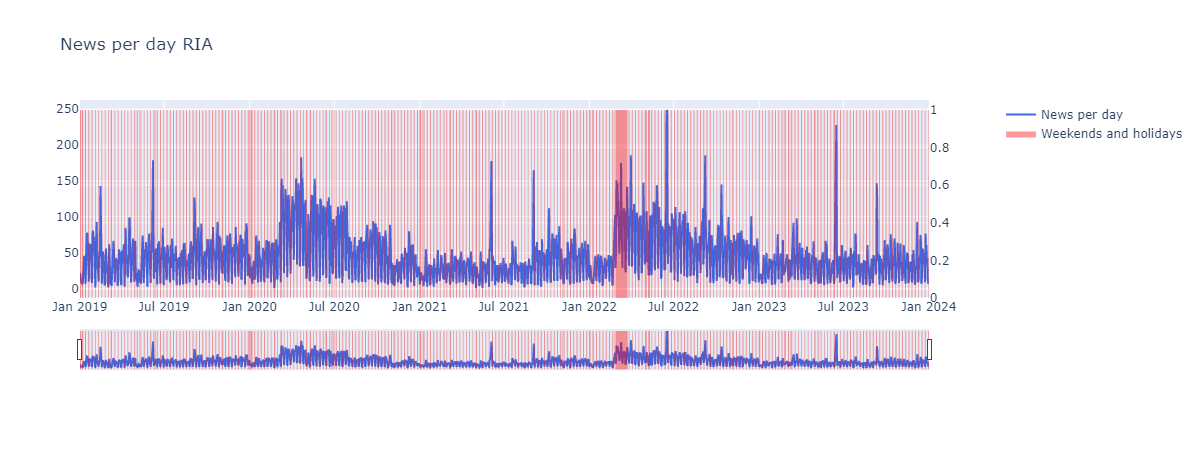

In [189]:
plot_news('RIA')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items was approximately 50 in 2019, 2021, 2023. In 2020 and 2022 there were gaps in the beginning of year and consequent reggression to average.

## Smart-lab

In [190]:
df_smart_lab = df_new[df_new['website']=='Smart_Lab']
df_smart_lab = df_smart_lab.reset_index()
df_smart_lab = df_smart_lab.drop('index', axis=1)

In [191]:
def datechanger(date):
    date = monthconvert(date)
    datetime_object = datetime.strptime(date, '%d %m %Y, %H:%M')
    return datetime_object

In [192]:
df_smart_lab['datetime'] = np.zeros(len(df_smart_lab))
for i in range(len(df_smart_lab)):
    df_smart_lab.loc[i, 'datetime'] = datechanger(df_smart_lab['date'][i])

C:\Users\maxod\AppData\Local\Temp\ipykernel_17032\1196443941.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2019-01-03 15:37:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [193]:
dates = []
for i in range(len(df_smart_lab)):
    dates.append(datetime.date(df_smart_lab['datetime'][i]))
df_smart_lab['date'] = dates

In [194]:
news_by_date = df_smart_lab.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

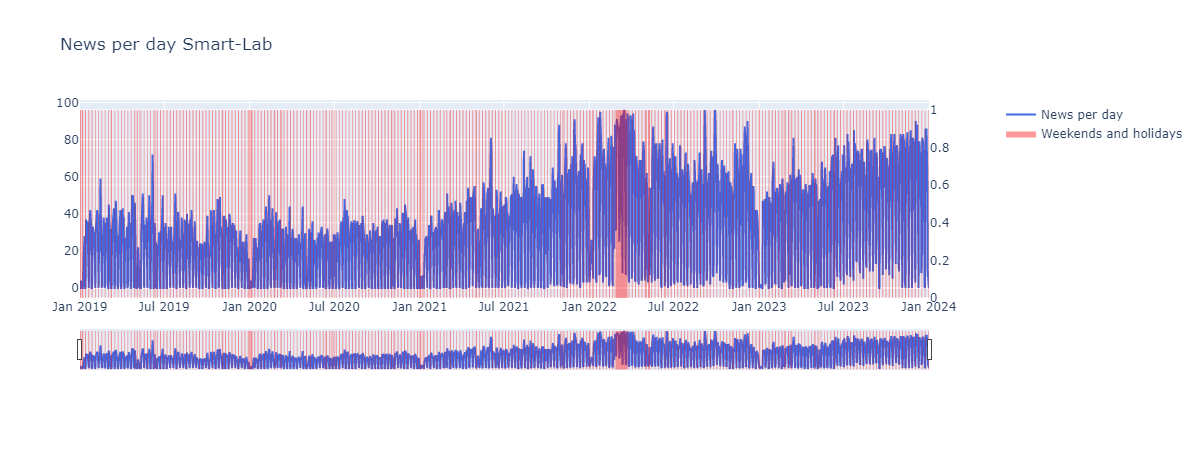

In [195]:
plot_news('Smart-Lab')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items has been approximately 70 since 2022. Before 2022 it had been around 40 news per day in average. It deviates from other sources in that there are many other dips in the number of news items. Possible reason: the nature of the portal itself, aggregation of news with lags.

## Kommersant

In [196]:
df_kommersant = df_new[df_new['website']=='Kommersant']
df_kommersant = df_kommersant.reset_index()
df_kommersant = df_kommersant.drop('index', axis=1)

In [197]:
df_kommersant['key_words'] = df_kommersant['key_words'].replace('[]', np.NaN)

In [198]:
df_kommersant['datetime'] = np.zeros(len(df_kommersant))
for i in range(len(df_kommersant)):
    df_kommersant.loc[i, 'datetime'] = datetime.strptime(df_kommersant['date'][i], '%d.%m.%Y, %H:%M')

C:\Users\maxod\AppData\Local\Temp\ipykernel_17032\527551317.py:3: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2023-11-23 14:18:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [199]:
dates = []
for i in range(len(df_kommersant)):
    dates.append(datetime.date(df_kommersant['datetime'][i]))
df_kommersant['date'] = dates

In [200]:
news_by_date = df_kommersant.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

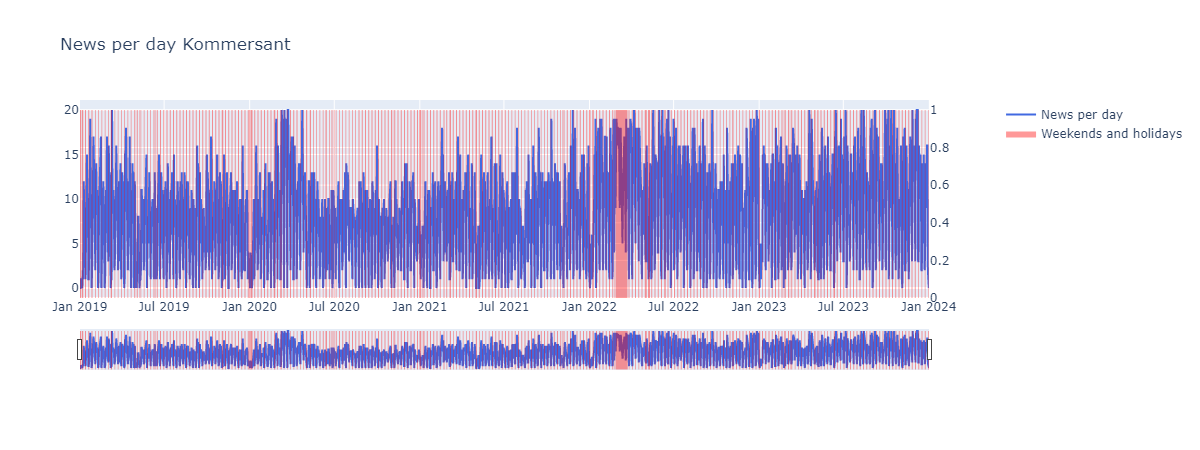

In [201]:
plot_news('Kommersant')

> __Interim conclusions:__ Most of the drop in the number of news coincides with weekends and holidays on which the exchange was not open. The average number of news items is approximately 12-13

## Common dataset

In [202]:
df_total = pd.concat(
    [df_interfax, df_ria, df_smart_lab, df_kommersant],
    axis=0,
    ignore_index=True
)

In [203]:
news_by_date = df_total.groupby('date').date.count()
news_by_date = news_by_date.reindex(s, fill_value=0)

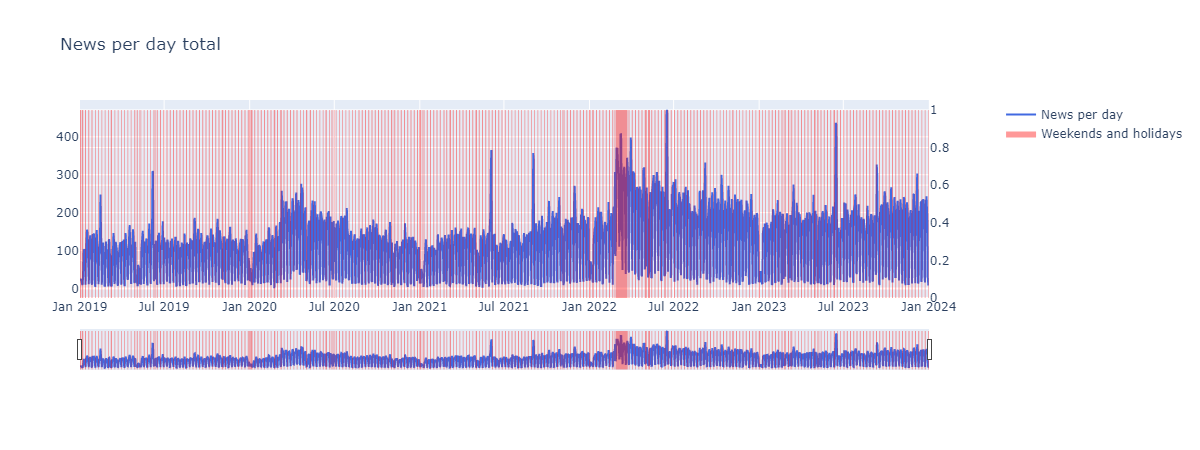

In [204]:
plot_news('total')

> __Intermediate conclusions:__ The general time series looks like a mixture of Interfax and RIA due to the amount of news from these publications. In the overall picture, a decrease in the number of news events even more often coincides with non-working days for the stock exchange. Increase in average number of news and variance is also present in general time series.

In [215]:
ts_total = df_total.copy()

In [216]:
ts_total.index = ts_total['datetime']

c:\Users\maxod\Desktop\project_graph\.venv\Lib\site-packages\pandas\core\indexes\base.py:7630: FutureWarning:

Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.



We will leave data only for dates that are available for all publications. 

Let's exclude days on which the exchange was not open. 

Let's limit ourselves to news, the influence of which can be tracked, taking news only in the intervals from 9:30 in the morning to half past 12 in the evening.

In [217]:
ts_total = ts_total[ts_total.index.weekday < 5].between_time('9:30', '23:30')
ts_total = ts_total[ts_total['date'].isin(pd.Series(working_days).dt.date.tolist())]
ts_total = ts_total.sort_index().loc['2019-01-01' : '2024-01-01', :] 

In [218]:
news_by_date = ts_total.groupby('date').date.count()

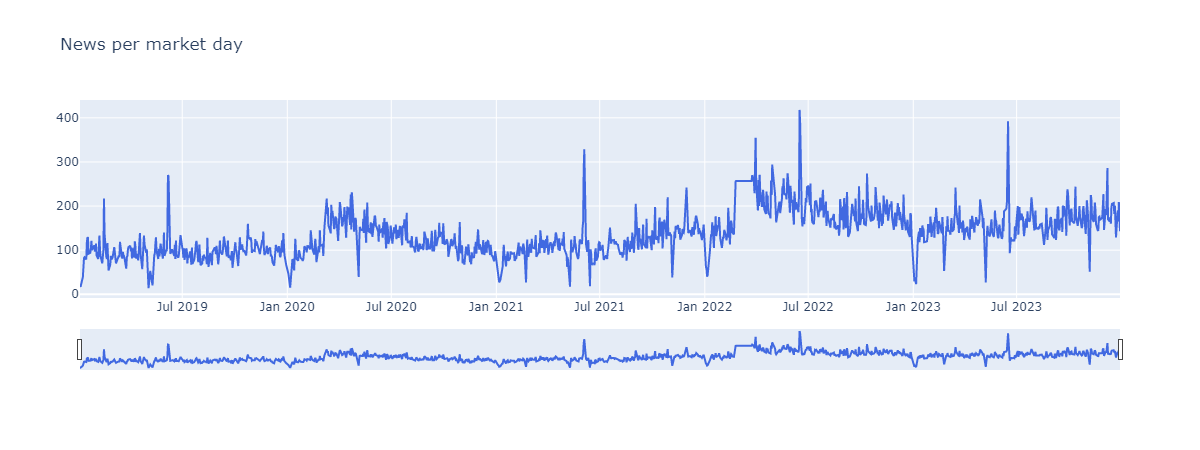

In [219]:
fig = go.Figure()
fig.add_trace(
        go.Scatter(x = list(news_by_date.index), y=list(news_by_date.values), 
                   line_color='rgba(65,105,225,1)', name='News per day', 
                   ))

fig.update_layout(
    title='News per market day',
    width=1200,
    height=450,
    xaxis=dict(
        rangeselector=dict(),
        rangeslider=dict(
            visible=True
        ),
        type="date"
        ))

fig.show('png')

> __Conclusions:__ 
> Based on the time series of news, it can be seen that the number of news has been fluctuating around the average of approximately 160-170 news per day on days when the Moscow Exchange is open since 2022. Before that it had been around 100-120 news.
> 
> There are some strong dips associated with weekends according to the general calendar, but the exchange was working on that day, so we did not exclude these dates. These are holidays of January, February, May. 
> 
> There is also a very busy day on June. This is probably due to the SPIEF.

In [220]:
len(ts_total)

169848

# Tags

In [221]:
total_tags_key_words = list()


#def list_enhancer(a):
#    a = a.strip('][').split(', ')
#    a = [i.replace("'", '') for i in a]
#    a = [i.replace('"', '') for i in a]
#    return a


for i in ts_total['key_words']:
    if np.any(i):
        total_tags_key_words.extend(i)

<Axes: title={'center': 'News with tags'}, xlabel='tags', ylabel='News'>

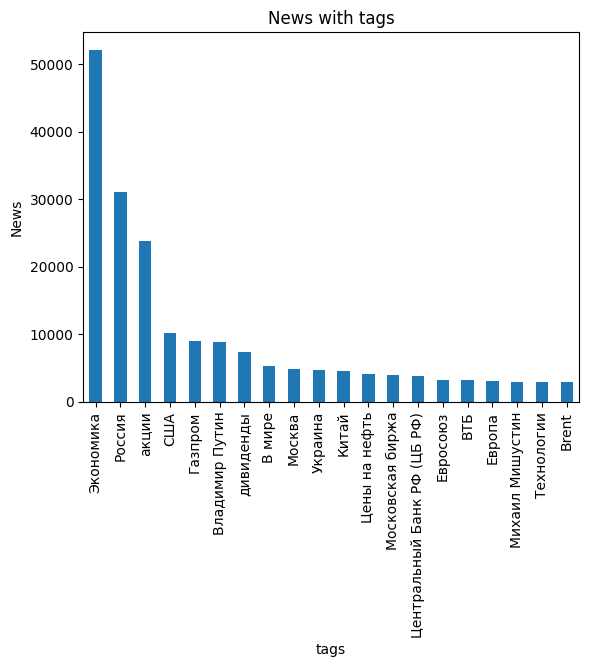

In [222]:
pd.Series(total_tags_key_words).value_counts().head(20).plot(kind='bar', title='News with tags', xlabel='tags', ylabel='News')

In [223]:
pd.Series(total_tags_key_words).value_counts().value_counts()

count
1      20677
2       4639
3       2135
4       1320
5        939
       ...  
510        1
522        1
523        1
530        1
274        1
Name: count, Length: 502, dtype: int64

In [224]:
pd.Series(total_tags_key_words).value_counts()

Экономика      52153
Россия         31134
акции          23793
США            10237
Газпром         9077
               ...  
D-Link             1
EDiMAX             1
Tenda              1
TP-Link            1
Крис Миллер        1
Name: count, Length: 35707, dtype: int64

> __Conclusions:__ 
> Most keywords appear a small number of times: 27000 tags and keywords appear 1 to 3 times. 
> 
> Most likely, rarely encountered tags will not reflect any entities, but perhaps among them there are synonyms or parts of entities that are reflected by more frequently occurring tags. 
> 
> At the data processing stage, we will try to extract a dictionary of entities. 
> 
> The most common keywords may also not be entities.

# Data export

In [225]:
ts_total.index = pd.RangeIndex(len(ts_total.index))
ts_total = ts_total.drop('date', axis=1)

In [226]:
ts_total

,website,section,url,header,body,key_words,body_length,datetime
0,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644973,"Нефть Brent подешевела до $54,25 за баррель",- Цены на нефть снижаются в четверг после по...,[Brent],2101,2019-01-03 09:38:00
1,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644976,Рынок акций РФ открылся снижением индексов Мос...,- Рынок акций РФ на первых в новом году торг...,[рынок акций],1961,2019-01-03 10:18:00
2,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/644980,Доллар в моменте обновил максимум марта 2016 г...,"По данным аналитиков, доллар вырос из-за разов...","[курсы валют, рубль, евро, доллар]",1048,2019-01-03 10:42:00
3,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/514388.php,Банк Открытие и Бинбанк - процесс объединения ...,"Банк ""ФК Открытие"" и Бинбанк — завершили проце...","[ФК Открытие, Бинбанк, Открытие]",882,2019-01-03 11:24:00
4,Ria,Экономика,https://ria.ru/20190103/1549006636.html,Рубль открыл год ростом к доллару и евро,Рубль открыл первые торги нового года уверен...,"[Экономика, Россия]",375,2019-01-03 11:49:00
...,...,...,...,...,...,...,...,...
169843,Kommersant,Финансы,https://www.kommersant.ru/doc/6440789,ЦБ изучит связанные с криптоактивами трансгран...,Банк России планирует в начале 2024 года изучи...,[],1529,2023-12-29 20:52:00
169844,Interfax,ЭКОНОМИКА,https://www.interfax.ru/business/938589,JD.com выиграла антимонопольное дело против ко...,- Китайская интернет-компания JD.com Inc. вы...,"[Alibaba, JD.com, Tmall, Китай]",675,2023-12-29 20:52:00
169845,Ria,Экономика,https://ria.ru/20231229/ssha-1919057051.html,"В США призвали ставить маячки на оборудование,...",Два американских эксперта в статье для New Y...,"[Экономика, Китай, США, Технологии, Россия, Ap...",1773,2023-12-29 21:00:00
169846,Ria,Экономика,https://ria.ru/20231229/kapital-1919057431.html,"Глава ""Иннопрактики"" и ее первый зам вошли в к...","Глава российского института развития ""Иннопр...","[Экономика, Технологии, Россия, Наталия Попова...",2063,2023-12-29 21:01:00


In [227]:
ts_total.to_parquet('../Data/trading_data_after_eda_5years.parquet')